In [2]:
%pip install tweepy
%pip install textblob
%pip install folium
%pip install pymongo
%pip install praw

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 99 kB 119 kB/s eta 0:00:01
     |████████████████████████████████| 151 kB 229 kB/s eta 0:00:01
     |████████████████████████████████| 64 kB 364 kB/s eta 0:00:01
     |████████████████████████████████| 197 kB 75 kB/s eta 0:00:011
     |████████████████████████████████| 128 kB 50 kB/s eta 0:00:01
     |████████████████████████████████| 166 kB 67 kB/s eta 0:00:01
     |████████████████████████████████| 70 kB 318 kB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 624 kB 113 kB/s eta 0:00:01     |██████████████████████████▎     | 512 kB 121 kB/s eta 0:00:01
     |████████████████████████████████| 1.

In [3]:
from nltk.corpus import stopwords
print(stopwords.words("english")[:10]) 


['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']


In [4]:
import os
import tweepy
import pandas as pd
import json
import re
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from pymongo import MongoClient
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import time


nltk.download('stopwords')
nltk.download('punkt')          #required for tokenization


/Users/shashankgoutam/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shashankgoutam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/shashankgoutam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
import praw

reddit = praw.Reddit(
    client_id="wpY9JdodcRVb4ECexcQHNw",
    client_secret="6Z4rqBqPK87SUjj9rRu08IsakFmz3w",
    user_agent="TrendAnalyzer/1.0",
    username="Affectionate_Hat4090",   
    password="Shashank@1508"    
)

try:
    reddit.user.me()
    print("Reddit API authentication successful!")
except Exception as e:
    print(f"Reddit API authentication failed: {e}")


Reddit API authentication successful!


In [6]:
from pymongo import MongoClient

try:
    client = MongoClient("mongodb://localhost:27017/")
    db = client["reddit_db"]  
    posts_collection = db["reddit_posts"]  
    print("Connected to MongoDB successfully!")
except Exception as e:
    print(f"MongoDB Connection Error: {e}")


Connected to MongoDB successfully!


In [7]:
subreddits = ["news", "worldnews", "technology"]

def fetch_reddit_posts():
    fetched_posts = []
    
    for subreddit in subreddits:
        for post in reddit.subreddit(subreddit).hot(limit=100):
            post_data = {
                "id": post.id,
                "title": post.title,
                "score": post.score,
                "created_utc": post.created_utc,
                "num_comments": post.num_comments,
                "url": post.url
            }
            fetched_posts.append(post_data)
            posts_collection.insert_one(post_data)
    
    print(f"{len(fetched_posts)} Reddit posts fetched and stored in MongoDB.")

fetch_reddit_posts()


300 Reddit posts fetched and stored in MongoDB.


In [ ]:
stop_words = set(stopwords.words("english"))

def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    text = text.lower()  
    text = re.sub(r"http\S+", "", text)  
    text = re.sub(r"[^a-zA-Z\s]", "", text)  
    text = " ".join(word for word in text.split() if word not in stop_words) 
    return text

def preprocess_data():
    posts = list(posts_collection.find())  
    df = pd.DataFrame(posts)

    if "title" in df.columns:
        df["clean_text"] = df["title"].apply(clean_text)  
    else:
        print("No 'title' column found in the dataset!")

    return df

df = preprocess_data()
df.head()


,_id,id,title,score,created_utc,num_comments,url,clean_text
0,67de71ce7b17eddec47a4a76,1jgy3y5,George Foreman: Heavyweight boxing legend dies...,12799,1.742610e+09,495,https://www.bbc.com/news/articles/ckg8ez8201yo,george foreman heavyweight boxing legend dies ...
1,67de71ce7b17eddec47a4a77,1jgt6pb,U.S. to revoke legal status of more than a hal...,10058,1.742595e+09,1136,https://www.cbsnews.com/news/u-s-to-revoke-leg...,us revoke legal status halfmillion migrants ur...
2,67de71ce7b17eddec47a4a78,1jgmnqx,Tate brothers say they have left US to return ...,14968,1.742579e+09,796,https://www.bbc.com/news/articles/cvgw0w7147vo,tate brothers say left us return romania
3,67de71ce7b17eddec47a4a79,1jgvn4r,US to import eggs from Turkey and South Korea ...,3118,1.742602e+09,619,https://www.bbc.com/news/articles/c743g135vj9o,us import eggs turkey south korea ease prices
4,67de71ce7b17eddec47a4a7a,1jgkhd3,Musk group offers $100 to Wisconsin voters ahe...,29464,1.742573e+09,1793,https://www.cnbc.com/2025/03/21/musk-group-off...,musk group offers wisconsin voters ahead pivot...


In [9]:
def analyze_sentiment(text):
    return TextBlob(text).sentiment.polarity

def perform_sentiment_analysis(df):
    df["sentiment"] = df["clean_text"].apply(analyze_sentiment)
    return df

df = perform_sentiment_analysis(df)
df.head()


,_id,id,title,score,created_utc,num_comments,url,clean_text,sentiment
0,67de71ce7b17eddec47a4a76,1jgy3y5,George Foreman: Heavyweight boxing legend dies...,12799,1.742610e+09,495,https://www.bbc.com/news/articles/ckg8ez8201yo,george foreman heavyweight boxing legend dies ...,-0.1
1,67de71ce7b17eddec47a4a77,1jgt6pb,U.S. to revoke legal status of more than a hal...,10058,1.742595e+09,1136,https://www.cbsnews.com/news/u-s-to-revoke-leg...,us revoke legal status halfmillion migrants ur...,0.2
2,67de71ce7b17eddec47a4a78,1jgmnqx,Tate brothers say they have left US to return ...,14968,1.742579e+09,796,https://www.bbc.com/news/articles/cvgw0w7147vo,tate brothers say left us return romania,0.0
3,67de71ce7b17eddec47a4a79,1jgvn4r,US to import eggs from Turkey and South Korea ...,3118,1.742602e+09,619,https://www.bbc.com/news/articles/c743g135vj9o,us import eggs turkey south korea ease prices,0.0
4,67de71ce7b17eddec47a4a7a,1jgkhd3,Musk group offers $100 to Wisconsin voters ahe...,29464,1.742573e+09,1793,https://www.cnbc.com/2025/03/21/musk-group-off...,musk group offers wisconsin voters ahead pivot...,0.3


In [10]:
def topic_modeling(df):
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words="english")
    dtm = vectorizer.fit_transform(df["clean_text"])
    lda = LatentDirichletAllocation(n_components=5, random_state=42)
    lda.fit(dtm)
    return lda, vectorizer

lda_model, vectorizer = topic_modeling(df)


In [11]:
def cluster_posts(df):
    vectorizer = CountVectorizer(stop_words="english")
    X = vectorizer.fit_transform(df["clean_text"])
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
    df["cluster"] = kmeans.fit_predict(X)
    return df

df = cluster_posts(df)
df.head()


,_id,id,title,score,created_utc,num_comments,url,clean_text,sentiment,cluster
0,67de71ce7b17eddec47a4a76,1jgy3y5,George Foreman: Heavyweight boxing legend dies...,12799,1.742610e+09,495,https://www.bbc.com/news/articles/ckg8ez8201yo,george foreman heavyweight boxing legend dies ...,-0.1,1
1,67de71ce7b17eddec47a4a77,1jgt6pb,U.S. to revoke legal status of more than a hal...,10058,1.742595e+09,1136,https://www.cbsnews.com/news/u-s-to-revoke-leg...,us revoke legal status halfmillion migrants ur...,0.2,0
2,67de71ce7b17eddec47a4a78,1jgmnqx,Tate brothers say they have left US to return ...,14968,1.742579e+09,796,https://www.bbc.com/news/articles/cvgw0w7147vo,tate brothers say left us return romania,0.0,0
3,67de71ce7b17eddec47a4a79,1jgvn4r,US to import eggs from Turkey and South Korea ...,3118,1.742602e+09,619,https://www.bbc.com/news/articles/c743g135vj9o,us import eggs turkey south korea ease prices,0.0,0
4,67de71ce7b17eddec47a4a7a,1jgkhd3,Musk group offers $100 to Wisconsin voters ahe...,29464,1.742573e+09,1793,https://www.cnbc.com/2025/03/21/musk-group-off...,musk group offers wisconsin voters ahead pivot...,0.3,0


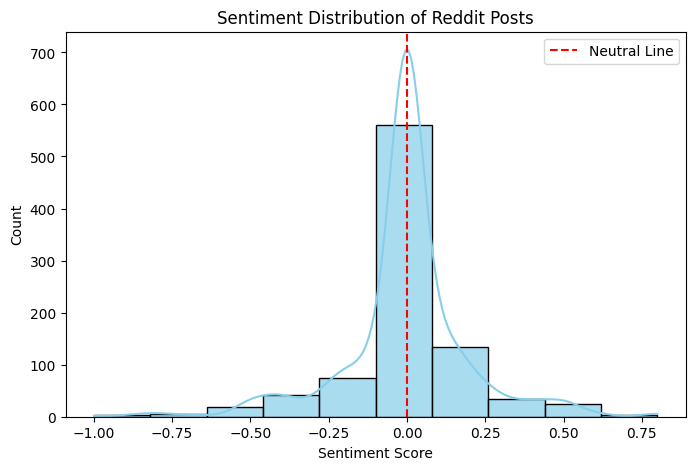

In [12]:
def plot_sentiment(df):
    plt.figure(figsize=(8, 5))
    sns.histplot(df["sentiment"], bins=10, kde=True, color="skyblue", alpha=0.7)
    plt.xlabel("Sentiment Score")
    plt.ylabel("Count")
    plt.title("Sentiment Distribution of Reddit Posts")
    plt.axvline(x=0, color="red", linestyle="--", label="Neutral Line")
    plt.legend()
    plt.show()

plot_sentiment(df)


In [13]:
def show_top_posts(df, sentiment_label="Positive", top_n=5):
    if sentiment_label == "Positive":
        top_posts = df.nlargest(top_n, "sentiment")
    else:
        top_posts = df.nsmallest(top_n, "sentiment")

    return top_posts[["title", "sentiment"]]

print("**Top 5 Positive Posts:**")
print(show_top_posts(df, "Positive"))

print("\n**Top 5 Negative Posts:**")
print(show_top_posts(df, "Negative"))


**Top 5 Positive Posts:**
                                                 title  sentiment
211  A Win for Encryption: France Rejects Backdoor ...        0.8
254  UCF Researchers Receive $600K Grant to Develop...        0.8
511  A Win for Encryption: France Rejects Backdoor ...        0.8
554  UCF Researchers Receive $600K Grant to Develop...        0.8
294  Huge win for Internet freedom: Google must sel...        0.6

**Top 5 Negative Posts:**
                                                 title  sentiment
611  Stocks close out their worst quarter since 202...     -1.000
186  US deportees face brutal conditions in El Salv...     -0.875
486  US deportees face brutal conditions in El Salv...     -0.875
219  Google claims news is worthless to its ad busi...     -0.800
519  Google claims news is worthless to its ad busi...     -0.800


In [15]:
def fetch_reddit_posts():
    subreddits = ["news", "worldnews", "technology"]

    for subreddit in subreddits:
        for post in reddit.subreddit(subreddit).hot(limit=100):
            post_data = {
                "id": post.id,
                "title": post.title,
                "score": post.score,
                "created_utc": post.created_utc,
                "num_comments": post.num_comments,
                "url": post.url
            }
            posts_collection.insert_one(post_data)

print("Reddit posts fetched and stored in MongoDB.")


Reddit posts fetched and stored in MongoDB.


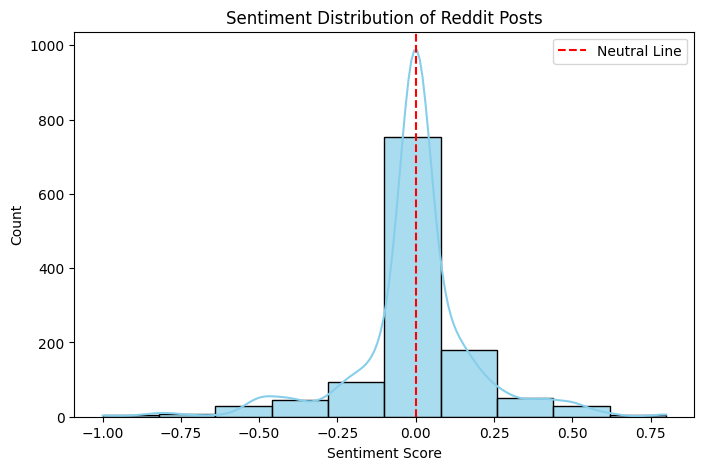

In [16]:
fetch_reddit_posts()  
df = preprocess_data()   # type: ignore
df = perform_sentiment_analysis(df)  
plot_sentiment(df)  
